# 06.1c: Initialization Check

**Goal:** Compare the degenerate embedding vector to typical initialization distributions.

The 814 degenerate tokens have identical embeddings because they're orphaned vocabulary entries that never received gradients. But did they move at all during training, or are they sitting exactly at initialization?

We'll:
1. Examine the norm and component statistics of the degenerate vector
2. Compare to the global distribution of embedding norms
3. Check against typical initialization schemes (Xavier, Kaiming, etc.)
4. Determine if these tokens moved during training or stayed at init

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Reference degenerate token
REFERENCE_TOKEN_ID = 149415

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Original Gamma Matrix

In [3]:
# Load original unembedding matrix (uncentered)
gamma_path = Path(TENSOR_DIR) / "gamma_qwen3_4b_instruct_2507.safetensors"
gamma = load_file(gamma_path)['gamma']

N, d = gamma.shape

print(f"Loaded γ (original unembedding matrix):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")

Loaded γ (original unembedding matrix):
  Tokens: 151,936
  Dimensions: 2,560


## Step 2: Examine Degenerate Vector

In [4]:
# Get the degenerate vector
degenerate_vector = gamma[REFERENCE_TOKEN_ID]

print(f"\nDegenerate vector (token {REFERENCE_TOKEN_ID}) in ORIGINAL gamma:")
print(f"  Norm: {degenerate_vector.norm().item():.12f}")
print(f"  Min component: {degenerate_vector.min().item():.12f}")
print(f"  Max component: {degenerate_vector.max().item():.12f}")
print(f"  Mean component: {degenerate_vector.mean().item():.12f}")
print(f"  Std component: {degenerate_vector.std().item():.12f}")
print(f"  Std (unbiased): {degenerate_vector.std(unbiased=True).item():.12f}")


Degenerate vector (token 149415) in ORIGINAL gamma:
  Norm: 0.370916754007
  Min component: -0.080078125000
  Max component: 0.049804687500
  Mean component: -0.000058443478
  Std component: 0.007332091685
  Std (unbiased): 0.007332091685


## Step 3: Global Distribution

In [5]:
# Compute norms for all tokens
all_norms = torch.norm(gamma, dim=1)

print(f"\nGlobal statistics for all {N:,} tokens:")
print(f"  Norm stats:")
print(f"    Min: {all_norms.min().item():.12f}")
print(f"    Max: {all_norms.max().item():.12f}")
print(f"    Mean: {all_norms.mean().item():.12f}")
print(f"    Median: {all_norms.median().item():.12f}")
print(f"    Std: {all_norms.std().item():.12f}")

# Where does the degenerate vector fall?
degenerate_norm = degenerate_vector.norm().item()
percentile = (all_norms < degenerate_norm).float().mean().item() * 100

print(f"\n  Degenerate vector norm: {degenerate_norm:.12f}")
print(f"  Percentile: {percentile:.2f}%")
print(f"  (i.e., {percentile:.1f}% of tokens have smaller norm)")


Global statistics for all 151,936 tokens:
  Norm stats:
    Min: 0.359538108110
    Max: 1.605024456978
    Mean: 1.087282896042
    Median: 1.114134311676
    Std: 0.168145999312

  Degenerate vector norm: 0.370916754007
  Percentile: 0.42%
  (i.e., 0.4% of tokens have smaller norm)


## Step 4: Compare to Standard Initialization Schemes

In [6]:
print("\n" + "="*60)
print("COMPARISON TO STANDARD INITIALIZATION SCHEMES")
print("="*60)

# Standard initialization schemes for embedding layers
# (vocab_size × hidden_dim matrices)

# 1. Xavier/Glorot Normal: N(0, sqrt(2/(fan_in + fan_out)))
# For embedding: fan_in = vocab_size, fan_out = hidden_dim
xavier_std = np.sqrt(2.0 / (N + d))
print(f"\n1. Xavier/Glorot Normal:")
print(f"   std = sqrt(2/(vocab_size + hidden_dim))")
print(f"   std = sqrt(2/({N} + {d})) = {xavier_std:.12f}")
print(f"   Expected norm = std * sqrt(d) = {xavier_std * np.sqrt(d):.12f}")

# 2. Xavier/Glorot Uniform: U(-a, a) where a = sqrt(6/(fan_in + fan_out))
xavier_uniform_a = np.sqrt(6.0 / (N + d))
xavier_uniform_std = xavier_uniform_a / np.sqrt(3)  # std of U(-a, a)
print(f"\n2. Xavier/Glorot Uniform:")
print(f"   a = sqrt(6/(vocab_size + hidden_dim)) = {xavier_uniform_a:.12f}")
print(f"   U(-{xavier_uniform_a:.12f}, {xavier_uniform_a:.12f})")
print(f"   std = a/sqrt(3) = {xavier_uniform_std:.12f}")
print(f"   Expected norm = std * sqrt(d) = {xavier_uniform_std * np.sqrt(d):.12f}")

# 3. Kaiming/He Normal: N(0, sqrt(2/fan_in))
# For embedding, fan_in could be interpreted as vocab_size or hidden_dim
# Let's try both
kaiming_std_vocab = np.sqrt(2.0 / N)
kaiming_std_hidden = np.sqrt(2.0 / d)
print(f"\n3. Kaiming/He Normal (fan_in = vocab_size):")
print(f"   std = sqrt(2/vocab_size) = {kaiming_std_vocab:.12f}")
print(f"   Expected norm = std * sqrt(d) = {kaiming_std_vocab * np.sqrt(d):.12f}")
print(f"\n4. Kaiming/He Normal (fan_in = hidden_dim):")
print(f"   std = sqrt(2/hidden_dim) = {kaiming_std_hidden:.12f}")
print(f"   Expected norm = std * sqrt(d) = {kaiming_std_hidden * np.sqrt(d):.12f}")

# 5. Standard Normal: N(0, 1)
print(f"\n5. Standard Normal N(0, 1):")
print(f"   std = 1.0")
print(f"   Expected norm = sqrt(d) = {np.sqrt(d):.12f}")

# 6. Small constant std (common for embeddings): N(0, 0.02) or N(0, 0.01)
for small_std in [0.02, 0.01, 0.005]:
    print(f"\n6. Small Normal N(0, {small_std}):")
    print(f"   Expected norm = {small_std} * sqrt(d) = {small_std * np.sqrt(d):.12f}")

print(f"\n" + "="*60)
print(f"ACTUAL DEGENERATE VECTOR NORM: {degenerate_norm:.12f}")
print("="*60)


COMPARISON TO STANDARD INITIALIZATION SCHEMES

1. Xavier/Glorot Normal:
   std = sqrt(2/(vocab_size + hidden_dim))
   std = sqrt(2/(151936 + 2560)) = 0.003597960391
   Expected norm = std * sqrt(d) = 0.182043996248

2. Xavier/Glorot Uniform:
   a = sqrt(6/(vocab_size + hidden_dim)) = 0.006231850200
   U(-0.006231850200, 0.006231850200)
   std = a/sqrt(3) = 0.003597960391
   Expected norm = std * sqrt(d) = 0.182043996248

3. Kaiming/He Normal (fan_in = vocab_size):
   std = sqrt(2/vocab_size) = 0.003628145151
   Expected norm = std * sqrt(d) = 0.183571237742

4. Kaiming/He Normal (fan_in = hidden_dim):
   std = sqrt(2/hidden_dim) = 0.027950849719
   Expected norm = std * sqrt(d) = 1.414213562373

5. Standard Normal N(0, 1):
   std = 1.0
   Expected norm = sqrt(d) = 50.596442562694

6. Small Normal N(0, 0.02):
   Expected norm = 0.02 * sqrt(d) = 1.011928851254

6. Small Normal N(0, 0.01):
   Expected norm = 0.01 * sqrt(d) = 0.505964425627

6. Small Normal N(0, 0.005):
   Expected norm =

## Step 5: Component Distribution Analysis


COMPONENT DISTRIBUTION

Degenerate vector component statistics:
  Mean: -0.000058443478
  Std: 0.007330659311
  Std (ddof=1): 0.007332091220
  Min: -0.080078125000
  Max: 0.049804687500
  Range: 0.129882812500


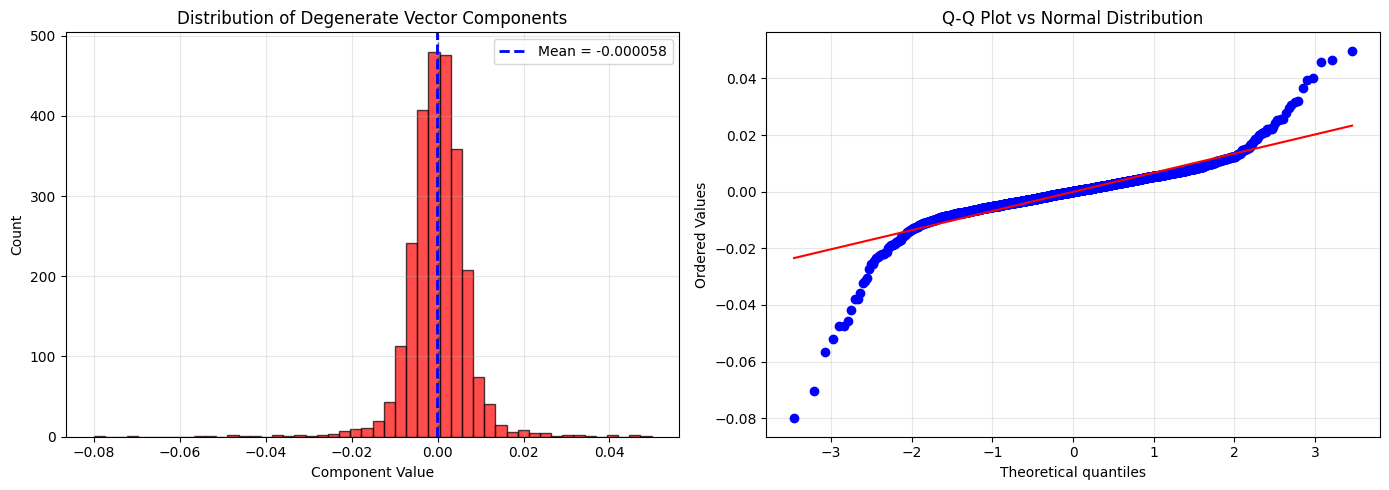


Shapiro-Wilk test for normality:
  Statistic: 0.851157
  P-value: 6.149842e-44
  Result: Distribution significantly differs from normal (p < 0.05)


In [7]:
print("\n" + "="*60)
print("COMPONENT DISTRIBUTION")
print("="*60)

# Analyze the distribution of components
components = degenerate_vector.cpu().numpy()

print(f"\nDegenerate vector component statistics:")
print(f"  Mean: {components.mean():.12f}")
print(f"  Std: {components.std():.12f}")
print(f"  Std (ddof=1): {components.std(ddof=1):.12f}")
print(f"  Min: {components.min():.12f}")
print(f"  Max: {components.max():.12f}")
print(f"  Range: {components.max() - components.min():.12f}")

# Histogram of components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Left: histogram
ax1.hist(components, bins=50, color='red', alpha=0.7, edgecolor='black')
ax1.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(components.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean = {components.mean():.6f}')
ax1.set_xlabel('Component Value')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Degenerate Vector Components')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Q-Q plot against normal distribution
from scipy import stats
stats.probplot(components, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot vs Normal Distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test for normality
statistic, p_value = stats.shapiro(components)
print(f"\nShapiro-Wilk test for normality:")
print(f"  Statistic: {statistic:.6f}")
print(f"  P-value: {p_value:.6e}")
if p_value > 0.05:
    print("  Result: Distribution is consistent with normal (p > 0.05)")
else:
    print("  Result: Distribution significantly differs from normal (p < 0.05)")

## Step 6: Visualize Against Global Distribution

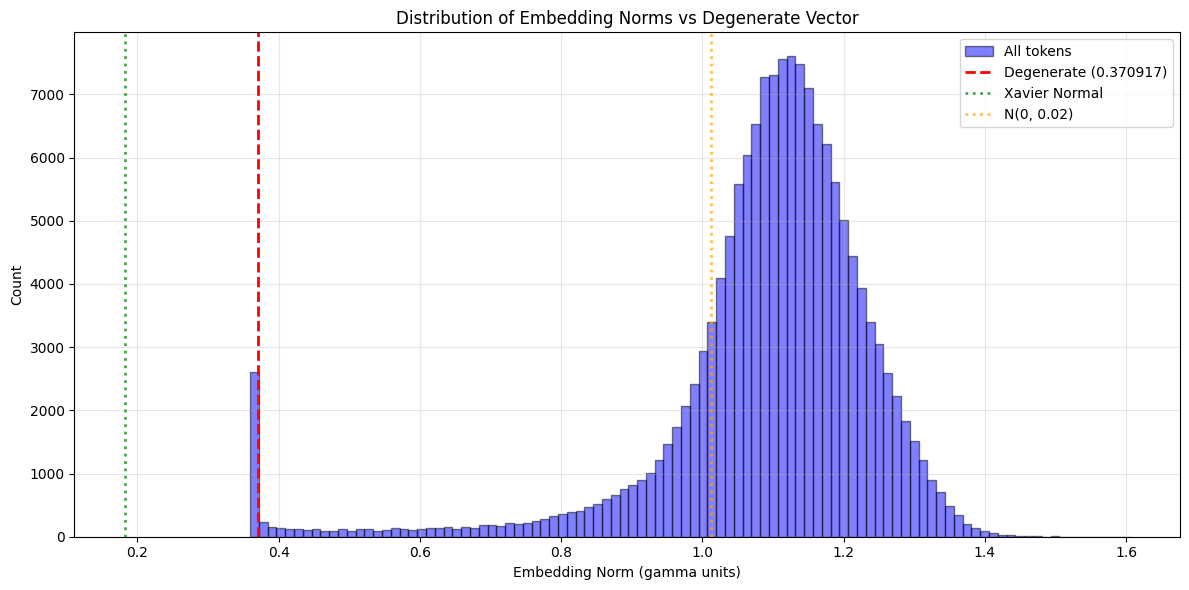


Degenerate vector is at 0.4th percentile of the norm distribution.


In [8]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

# Histogram of all norms
ax.hist(all_norms.cpu().numpy(), bins=100, color='blue', alpha=0.5, label='All tokens', edgecolor='black')

# Mark degenerate vector
ax.axvline(degenerate_norm, color='red', linestyle='--', linewidth=2, label=f'Degenerate ({degenerate_norm:.6f})')

# Mark expected initialization norms
ax.axvline(xavier_std * np.sqrt(d), color='green', linestyle=':', linewidth=2, alpha=0.7, label='Xavier Normal')
ax.axvline(0.02 * np.sqrt(d), color='orange', linestyle=':', linewidth=2, alpha=0.7, label='N(0, 0.02)')

ax.set_xlabel('Embedding Norm (gamma units)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Embedding Norms vs Degenerate Vector')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nDegenerate vector is at {percentile:.1f}th percentile of the norm distribution.")

## Summary

This notebook compares the degenerate embedding vector to typical initialization schemes.

**Key questions:**
- What is the norm of the degenerate vector?
- How does it compare to expected initialization norms (Xavier, Kaiming, small constant)?
- Are the components normally distributed as expected from initialization?
- Where does it fall in the global distribution of embedding norms?

If the degenerate vector's norm and component distribution match a standard initialization scheme, it suggests these tokens never moved during training (stayed at init). If they differ significantly, the tokens may have received some gradients before being orphaned.